In [1]:
import os
import re
import math
import time
import torch

import librosa
import librosa.display
import itertools
import functools
import torchaudio
import torchvision
import torch.optim


import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F
from torch.utils.data import DataLoader

import IPython.display as ipd

from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch import nn, einsum
from inspect import isfunction



import torchaudio.transforms as T

import IPython.display as ipd
import sentencepiece as spm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


import torch.utils.data
from librosa.util import normalize
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn

import pickle
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel

MAX_WAV_VALUE = 32768.0
from torch import nn, einsum
from einops import rearrange, repeat




In [6]:
is_cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda:0


In [10]:
from hifi_gan import Generator as hifigan_vocoder
from omegaconf import OmegaConf

path_config = 'hifi_gan.json'
path_ckpt = 'g_02500000'

hifigan_config = OmegaConf.load(path_config)
vocoder = hifigan_vocoder(hifigan_config)

state_dict_g = torch.load(path_ckpt)
vocoder = vocoder.to(device)
vocoder.load_state_dict(state_dict_g['generator'])
vocoder.eval()

Generator(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (resblocks): ModuleList(
    (0): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride

In [11]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)
    # return torch.clamp(x, min=clip_val) * C


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output


sr = 22050
n_fft = 1024
win_length = n_fft
hop_length = 256

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft=n_fft, num_mels=80, sampling_rate= sr, hop_size=hop_length, win_size=win_length, fmin=0, fmax=8000, center=False):
    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax) + '_' + str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)
    
    #print(y.shape) # 45237, 1 (1024-256)/2, (1024-256)/2
    y = torch.nn.functional.pad(y.unsqueeze(0), ((int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2))),
                                mode='reflect')
    y = y.squeeze(1)
    
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex = False) # return_complex =False

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9)) #???

    spec = torch.matmul(mel_basis[str(fmax) + '_' + str(y.device)], spec)
        
    spec = librosa.power_to_db(spec, ref=np.max, top_db = num_mels) ## dB 단위로 변형 numpy로 결과가 나옴
    

    spec = (spec / 80.0) + 1

    
    return torch.from_numpy(spec.astype("float32")) ## numpy를 torch로

In [12]:
def inference_to_audio(x, sr = 22050, n_mels = 80):
    
    inference_ = (x.cpu() - 1) * 80.0

    S = librosa.db_to_power(inference_)

    zxc = spectral_normalize_torch(S.squeeze()) ## 나온 power 정규화 필수
    
    conv_wav = vocoder(zxc.to(device)) 
    
    conv_wav = conv_wav.squeeze().detach().cpu().numpy()
    
    print(librosa.display.waveshow(conv_wav))
    
    return conv_wav

In [13]:
def collate_fn(batch):
    
    src_speech = [] 
    
    for samples, sr, text, speaker, idx in batch:                    
                
        resample_audio = torchaudio.functional.resample(samples, orig_freq=sr, new_freq=22050) ## [1,153600]
        
        rand_cut = resample_audio.shape[1] - 32802
        
        if rand_cut < 0:
            continue
        
        else:
            start_sample = torch.randint(0, rand_cut, (1,)).int().item()

        mel_spec = mel_spectrogram(resample_audio[0][start_sample:start_sample + 32802])
                
        src_speech.append(mel_spec.squeeze().permute(1,0)) 
        
    
    speech_batch = pad_sequence(src_speech, padding_value = 0.0, batch_first = True) # batch, Frame, mel
    
    speech_batch =speech_batch.permute(0,2,1)
    
    return speech_batch.unsqueeze(1) ## batch, 1, mel, time

In [14]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, cemb= None, *args, **kwargs):
        return self.fn(x, cemb, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [16]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x



class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x, cemb= None):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x, cemb= None):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(query_dim, inner_dim, 1, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Conv2d(inner_dim, query_dim, 1),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None):
        x_b, x_c, x_h, x_w = x.shape
        
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context) ## batch, n, dim (batch, 1, dim)
        v = self.to_v(context)
        
        q = rearrange(q, "b (h c) x y -> b (x y) (h c)", h=self.heads) ## batch, dim, x, y -> batch, (x*y) dim
        
        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale ## batch, (x,y), n
    
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v) ## (batch, (x*y), dim) 
        out = rearrange(out, 'b (x y) (h c) -> b (h c) x y', x= x_h, h=h)
        
        return self.to_out(out)


In [18]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x, cemb=None):
        x = self.norm(x)
        return self.fn(x, cemb)

In [19]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [20]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape): ## 인덱스에 해당되는 노이즈 추출 #[batch, 1,1,1]
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [21]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [22]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image


In [23]:
def p_losses(denoise_model, x_start, t, cemb, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, cemb)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [24]:
@torch.no_grad()
def p_sample(model, x, t, cemb, t_index, w):
    '''
    
    w: classifier scaler
    
    '''
    
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    
    
    alphas_t = extract(alphas, t, x.shape)
    
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    
    #interpolation condition, uncondition in 'Classfier-free diffusion guidance' Algorithm 2, line 3.
    
    cemb_shape = cemb.shape
    
    pred_eps_cond = model(x, t, cemb) ## 컨디션을 받은 모델의 결과
    
    zeros_condition = torch.zeros(cemb_shape, device = device)  ## Zero condition
    
    pred_eps_uncond = model(x,t, zeros_condition)    ## 컨디션을 안받은 모델의 결과
    
    pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond) ## Conditioned + Unconditioned 결과를 interpolation 하여 Guidance 로 활용
    
    model_mean = sqrt_recip_alphas_t * (
       x - betas_t * pred_eps / sqrt_one_minus_alphas_cumprod_t
    )
    
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, cemb, shape, w):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), cemb, i, w=w)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, cemb, w = 1.0, batch_size=16, channels=3):
    return p_sample_loop(model, cemb, w= w, shape=(batch_size, channels, image_size[0], image_size[1]))

In [25]:


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        cdim = 10,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)
        self.cdim = cdim

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: init_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)
        
        #uncond_klass = partial(Uncond_ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = init_dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(init_dim),
            nn.Linear(init_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        
        # conditional Embedding #[batch, 10]
        self.cemb_layer = nn.Sequential(
            nn.Linear(self.cdim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )
        
        

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, CrossAttention(dim_in, context_dim = time_dim))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, CrossAttention(dim_out, time_dim))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        
        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(init_dim * 2, init_dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)

    def forward(self, x, time, cemb, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        cemb = self.cemb_layer(cemb)[:,None]
        
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x, cemb)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x, cemb)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [26]:
class ConditionalEmbedding(nn.Module):
    def __init__(self, num_labels:int, d_model:int, dim:int):
        assert d_model % 2 == 0
        super().__init__()
        self.condEmbedding = nn.Sequential(
            nn.Embedding(num_embeddings=num_labels + 1, embedding_dim=d_model, padding_idx=10),
            nn.Linear(d_model, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, t:torch.Tensor) -> torch.Tensor:
        emb = self.condEmbedding(t)
        return emb

cemblayer = ConditionalEmbedding(10, 10, 10).to(device)

In [27]:
class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None,):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        
        total_len = len(self.file_list)
        
                    
    def __getitem__(self, idx):
        try:
            audio, sr = torchaudio.load(self.file_list[idx])
            label = self.label_list[idx]
            return audio, sr, label
        except:
            audio, sr = torchaudio.load(self.file_list[0])
            label = self.label_list[idx]
            return audio, sr, label
    
    def __len__(self):
        return len(self.file_list)

In [28]:
def collate_fn(batch):
    
    src_speech = [] 
    src_label = []
    
    for samples, sr, label in batch:                    
                
        resample_audio = torchaudio.functional.resample(samples, orig_freq=sr, new_freq=22050) ## [1,153600]
        
        mel_spec = mel_spectrogram(resample_audio[0][:14512])
                
        src_speech.append(mel_spec.squeeze().permute(1,0)) 
        
        src_label.append(label)
    
    speech_batch = pad_sequence(src_speech, padding_value = 0.0, batch_first = True) # batch, Frame, mel
    
    speech_batch =speech_batch.permute(0,2,1)
    
    return speech_batch.unsqueeze(1), torch.tensor(src_label) ## batch, 1, mel, time

In [29]:
import torchvision.transforms as T

batch_size = 32

train_ds = AudioDataset('../data/', label_transform=T.ToTensor())

data_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    collate_fn = collate_fn,
    num_workers = 8,
    shuffle=True,
    pin_memory = True,
    drop_last = True
)


In [ ]:
a,b = next(iter(data_loader))

In [30]:
model = Unet(
    dim=56,
    channels=1,
    init_dim = 32,
    cdim = 10,
    dim_mults=(1, 2, 2, 4),
    resnet_block_groups = 32,
)

model.to(device)

optimizer = torch.optim.AdamW(itertools.chain(model.parameters(), cemblayer.parameters()), lr=5e-4)

In [ ]:
from torchvision.utils import save_image

epochs = 300
before_loss = 999999.0
saved_epoch = 0

threshold = 0.1

for epoch in range(epochs):
    
    total_loss = 0

    for step, batch in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()

        batch_size = batch[0].shape[0]
        image = batch[0].to(device)
        label = batch[1].to(device)
        
        cemb = cemblayer(label)
        
        # threshold 미만인 부분은 unconditional 한 방식으로 학습
        cemb[np.where(np.random.rand(batch_size)< threshold)] = 0

       # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, image, t, cemb, loss_type="huber")
        
        total_loss += loss

        loss.backward()
        optimizer.step()

        
    total_loss = total_loss / len(data_loader)
    print(f"epoch : {epoch} Loss : {total_loss} ")
    
    if before_loss > total_loss:
            saved_epoch = epoch
            print(f"before_loss = {before_loss:.4f}, loss = {total_loss:.4f}, saved_epoch = {saved_epoch}" )
            print('model_save')
            torch.save(cemblayer.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/DDPM_Speech_Guide_embedding_layer_CrossAttention.pth')
            torch.save(model.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/DDPM_Speech_Guided_CrossAttention.pth') ## 변경
            before_loss = total_loss



In [213]:

ckpt = torch.load('../weights/DDPM_Speech_Guided_CrossAttention.pth', map_location=device) # DDPM_Speech_Guided_CrossAttention
model.load_state_dict(ckpt)
ckpt = torch.load('../weights/DDPM_Speech_Guide_embedding_layer_CrossAttention.pth', map_location=device) # DDPM_Speech_Guide_embedding_layer_CrossAttention
cemblayer.load_state_dict(ckpt)
model.eval()
cemblayer.eval()

ConditionalEmbedding(
  (condEmbedding): Sequential(
    (0): Embedding(11, 10, padding_idx=10)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): SiLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [321]:
classes = torch.randint(low=0, high=10, size=(64,), device=device)
classes

tensor([2, 4, 1, 3, 1, 0, 2, 6, 0, 8, 8, 0, 7, 9, 8, 6, 8, 2, 9, 5, 5, 1, 7, 1,
        0, 5, 9, 4, 9, 4, 8, 7, 0, 7, 7, 1, 5, 5, 5, 5, 9, 7, 4, 0, 8, 2, 6, 4,
        2, 2, 6, 6, 9, 9, 3, 5, 3, 8, 3, 7, 1, 7, 9, 7], device='cuda:0')

In [551]:
samples = sample(model, cemb = cemblayer(classes), w= 4.0, image_size=(80,56), batch_size=64, channels=1)

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.52it/s]


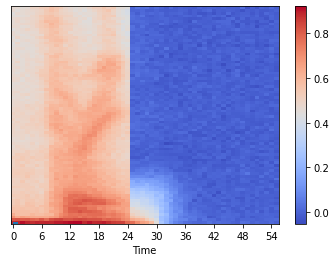

In [583]:
results = samples[-1][3]
fig, ax = plt.subplots()
img = librosa.display.specshow(results.squeeze())
fig.colorbar(img, ax=ax)
a = inference_to_audio(torch.tensor(results))
ipd.Audio(a, rate= 22050)


## Noisy data 생성

In [ ]:
## Korean Speech
inference_data = torchaudio.load('kss_data/kss/4/4_5631.wav')[0] ## 학습에 사용하지 않은 이외의 데이터
inference_resample_audio = torchaudio.functional.resample(inference_data, orig_freq=44100, new_freq=22050)
inference_mel= mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) ## [1,80,128] 



In [ ]:
inference_resample_audio = torchaudio.functional.resample(dataset[1][0], orig_freq=48000, new_freq=22050)
inference_mel = mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) #[11025:32802+11025]

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(inference_mel[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(inference_mel[0])
ipd.Audio(a, rate= 22050)


In [ ]:
nosiy_data = q_sample(inference_mel, torch.tensor([40]))
fig, ax = plt.subplots()
img = librosa.display.specshow(nosiy_data[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(nosiy_data[0])
ipd.Audio(a, rate= 22050)

In [ ]:
inference_mel.shape

In [ ]:
torch.randn(1,80,507).chunk(2,2)[0].shape

In [ ]:

# Algorithm 2 (including returning all images)
@torch.no_grad()
def Enhancement_p_sample_loop(model, shape, image, timesteps):
    device = next(model.parameters()).device
    
    timesteps = timesteps 

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = image.to(device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs



In [ ]:
result = Enhancement_p_sample_loop(model, shape = (1,1,80,128), image = nosiy_data.unsqueeze(0), timesteps= 50)

In [ ]:

fig, ax = plt.subplots()
img = librosa.display.specshow(result[-1][0][0])
fig.colorbar(img, ax=ax)
a = inference_to_audio(torch.tensor(result[-1][0]))
ipd.Audio(a, rate= 22050)

In [ ]:
result[-1][0].shape

In [ ]:
a= inference_to_audio(torch.tensor(samples[-1][7], device= device))
ipd.Audio(a, rate= 22050)

In [285]:
timesteps

300

# DDIM Sampling

In [808]:
@torch.no_grad()
def ddim_p_sample(model, x, t, prev_t, cemb, t_index, prev_index, w, eta = 0,):
    '''
    
    w: classifier scaler
    
    '''

    #alphas_t = extract(alphas, t, x.shape)
    
    alphas_cumprod_t = extract(alphas_cumprod, t, x.shape)
    
    alphas_cumprod_prev_t = extract(alphas_cumprod_prev, prev_t, x.shape)
    
    
    sigmas_t = torch.sqrt((1 - alphas_cumprod_prev_t) / (1 - alphas_cumprod_t) * (1 - alphas_cumprod_t / alphas_cumprod_prev_t))

        
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    
    #interpolation condition, uncondition in 'Classfier-free diffusion guidance' Algorithm 2, line 3.
    
    cemb_shape = cemb.shape
    
    pred_eps_cond = model(x, t, cemb) ## 컨디션을 받은 모델의 결과
    
    zeros_condition = torch.zeros(cemb_shape, device = device)  ## Zero condition
    
    pred_eps_uncond = model(x,t, zeros_condition)    ## 컨디션을 안받은 모델의 결과
    
    pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond) ## Conditioned + Unconditioned 결과를 interpolation 하여 Guidance 로 활용

    ## DDIM sigma 
    sigma = sigmas_t * eta
    p_var = sigma**2
    
    predicted_x0 = torch.sqrt(alphas_cumprod_prev_t) * (x - torch.sqrt(1 - alphas_cumprod_t) * pred_eps) / torch.sqrt(alphas_cumprod_t)
    direction_pointing_to_xt = torch.sqrt(1 - alphas_cumprod_prev_t - p_var) * pred_eps
    
    noise = torch.randn_like(x)
    
    p_mean = predicted_x0 + direction_pointing_to_xt
    
    if t_index == 0:
        return  p_mean + torch.sqrt(p_var)
    else:
        # Algorithm 2 line 4:
        return p_mean + torch.sqrt(p_var) * noise
    
    

# Algorithm 2 (including returning all images)
@torch.no_grad()
def ddim_p_sample_loop(model, imgg, cemb, shape, w, eta, tau):
    device = next(model.parameters()).device
    

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = imgg#torch.randn(shape, device=device)
    imgs = []
    
    
    diffusion_process =list(range(0, timesteps, tau)) + [timesteps-1] ## tau로 샘플링 횟수 조정
    
    diffusion_process = zip(reversed(diffusion_process[:-1]), reversed(diffusion_process[1:]))
    
    for prev_index, index in tqdm(diffusion_process, desc='sampling loop time step'):
        img = ddim_p_sample(model, img, torch.full((b,), index, device=device, dtype=torch.long), 
                            torch.full((b,), prev_index, device=device, dtype=torch.long), 
                            cemb, index, prev_index, w=w, eta = eta)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def ddim_sample(model, imgg, image_size, cemb, w = 1.0, batch_size=16, channels=3, eta =0, tau = 1):
    return ddim_p_sample_loop(model, imgg, cemb, w= w, shape=(batch_size, channels, image_size[0], image_size[1]), eta= eta, tau=tau)

In [807]:
imgg = torch.randn(64,1,80,56, device=device)

In [1057]:
classes

tensor([2, 4, 1, 3, 1, 0, 2, 6, 0, 8, 8, 0, 7, 9, 8, 6, 8, 2, 9, 5, 5, 1, 7, 1,
        0, 5, 9, 4, 9, 4, 8, 7, 0, 7, 7, 1, 5, 5, 5, 5, 9, 7, 4, 0, 8, 2, 6, 4,
        2, 2, 6, 6, 9, 9, 3, 5, 3, 8, 3, 7, 1, 7, 9, 7], device='cuda:0')

In [1049]:
samples = ddim_sample(model,imgg, cemb = cemblayer(classes), w= 2.0, image_size=(80,56), batch_size=64, channels=1, eta = 1, tau= 20)

sampling loop time step: 15it [00:00, 17.93it/s]


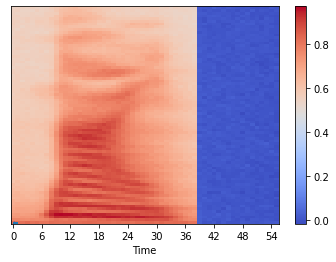

In [1079]:
results = samples[-1][26]
fig, ax = plt.subplots()
img = librosa.display.specshow(results.squeeze())
fig.colorbar(img, ax=ax)
a = inference_to_audio(torch.tensor(results))
ipd.Audio(a, rate= 22050)